In [1]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

### Model training

In [4]:
EXPERIMENT_NAME = 'cnn_att'
DATASET_NAME = 'mirna_fcs'
MIRNA_NAME = 'hsa-miR-106b-5p'

RANDOM_STATE = 42
BATCH_SIZE = 32

In [6]:
from data_manipulation import download_data_from_github_if_not_existing

download_data_from_github_if_not_existing(
    url = "https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRNA/main/modules/evaluation/mirna_fcs.csv",
    output_file_path = 'data/{}.csv'.format(DATASET_NAME),
)

'data/mirna_fcs.csv'

In [7]:
from pytorch_lightning.loggers import CometLogger

comet_logger = CometLogger(
    api_key="EpKIINrla6U4B4LJhd9Sv4i0b",
    project_name="mirna",
)

CometLogger will be initialized in online mode


In [9]:
import pandas as pd

input_dataset_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.normalize.pkl'.format(DATASET_NAME, MIRNA_NAME)
df_train = pd.read_pickle(input_dataset_file_path_train)

input_dataset_file_path_test = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.pkl'.format(DATASET_NAME, MIRNA_NAME)
df_test = pd.read_pickle(input_dataset_file_path_test)

In [10]:
def pad_2d_array_to_longest_subarray_length(arr, pad_value=0):
    # Find the maximum length of sublists
    max_len = max(len(sublist) for sublist in arr)
    
    # Pad the sublists to max length
    padded_arr = [sublist + [pad_value] * (max_len - len(sublist)) for sublist in arr]
    
    return padded_arr

In [11]:
df_train['signal'] = pad_2d_array_to_longest_subarray_length(df_train['signal'])
df_test['signal'] = pad_2d_array_to_longest_subarray_length(df_test['signal'])

In [12]:
from sklearn.model_selection import train_test_split

#split validation set
df_train, df_val = train_test_split(
    df_train, 
    test_size = 0.1, 
    random_state = RANDOM_STATE,
    shuffle=True
)

In [13]:
print(
    df_train['gene_symbol'].size, 
    df_test['gene_symbol'].size,
    df_val['gene_symbol'].size,
)

3582 2023 399


In [14]:
from dataset import get_train_dataloader, get_val_dataloader, get_test_dataloader
import torch

train_loader = get_train_dataloader([torch.tensor(x) for x in df_train['signal']], df_train['fold_change'].values, BATCH_SIZE)
val_loader = get_val_dataloader([torch.tensor(x) for x in df_val['signal']], df_val['fold_change'].values, BATCH_SIZE)
test_loader = get_test_dataloader([torch.tensor(x) for x in df_test['signal']], df_test['fold_change'].values, BATCH_SIZE)

In [15]:
from model import Small_CNN

from pytorch_lightning import Trainer
from IPython.utils import io


model = Small_CNN(
    pooling='att',
    # pooling='max',
    # pooling='rnn',
    lr=1e-3,
    warmup_steps=1,
    wd=0.01,
    logging_steps=1,
    pos_weight=1.0,
    num_cnn_layers=4,
)
# trainer = Trainer(max_epochs=1, gpus=1)  # Use GPU if available
trainer = Trainer(logger=comet_logger, max_epochs=20)  

# capture_output to have a cleaner notebook
# you can follow the training at the  https://www.comet.com/davidcechak/mirna/  see log of this cell
with io.capture_output() as captured:
    trainer.fit(model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | architecture | Sequential        | 13.0 K
1 | ce           | MSELoss           | 0     
2 | mae          | MeanAbsoluteError | 0     
3 | mse          | MeanSquaredError  | 0     
4 | r2           | R2Score           | 0     
---------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a

### Model prediction

In [16]:
from dataset import predict

gene_to_predictions, predictions = predict(model, [torch.tensor(x) for x in df_test['signal']], df_test['gene_symbol'].values)

In [17]:
from utils import get_experiment_time_id

experiment_id = get_experiment_time_id(sufix=EXPERIMENT_NAME)
experiment_id

'07-11-23_23-42.cnn_att'

In [18]:
from data_manipulation import add_predictions_to_test_dataframe

method_predictions, results_file_path = add_predictions_to_test_dataframe(
    df_test,
    gene_to_predictions,
    output_file_path = 'results/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.{}.pkl'.format(
        DATASET_NAME,
        MIRNA_NAME,
        experiment_id,
    )
)

In [19]:
method_predictions[['fold_change', 'prediction']].corr()

,fold_change,prediction
fold_change,1.000000,0.060423
prediction,0.060423,1.000000


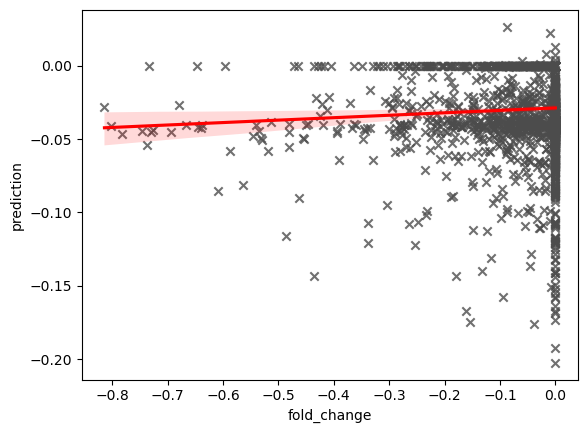

In [20]:
import seaborn as sns

sns.regplot(
    data=method_predictions[['fold_change', 'prediction']], 
    x="fold_change",
    y="prediction", 
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)